**Import data, view dataframe structure**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None

df_train = pd.read_csv('titanic_train.csv')

df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**Isolate letter in Cabin feature and find where NaNs exist**

Cabin coverage is sparse, but letter is not - may relate to deck and if so may be significant. Using get_dummies results in 0's across the newly created columns for NaN.

In [2]:
CabinLetter = df_train['Cabin']
CabinLetter[CabinLetter.notnull()] = [x[0] for i, x in enumerate(CabinLetter[CabinLetter.notnull()])]

df_train['CabinLetter'] = CabinLetter

X = pd.get_dummies(df_train.drop(columns=['Survived','Name','Ticket','Cabin','PassengerId']))
y = df_train['Survived']
X = X.drop(columns=['Sex_male']) #Sex feature is binary, don't need both
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 
X = X_train
y=y_train
X.isna().sum()

Pclass             0
Age              133
SibSp              0
Parch              0
Fare               0
Sex_female         0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
CabinLetter_A      0
CabinLetter_B      0
CabinLetter_C      0
CabinLetter_D      0
CabinLetter_E      0
CabinLetter_F      0
CabinLetter_G      0
CabinLetter_T      0
dtype: int64

**Create dummy classifier as baseline check**

In [3]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

dc_strat = DummyClassifier(strategy = 'stratified').fit(X_train, y_train)

y_dummy_predict = dc_strat.predict(X_test)
confusion = confusion_matrix(y_test, y_dummy_predict)

print('Stratified dummy classifier\n', confusion)
print('Accuracy of dummy classifier',accuracy_score(y_test,y_dummy_predict))

Stratified dummy classifier
 [[81 58]
 [50 34]]
Accuracy of dummy classifier 0.515695067264574


**Perform logistic regression**

Using a simple imputer to fill in Ages (NA for CabinLetter shows as 0 for all values)
Compare accuracy using ridge method with varying C values

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),('lr',LogisticRegression(solver='liblinear',penalty='l2'))])

param_grid = {
    'lr__C': np.logspace(-4, 4, 9)
}
search = GridSearchCV(pipe, param_grid,cv=5)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.795):
{'lr__C': 10.0}


In [5]:
def plot_gridsearchcv_results(gridsearch,score,logvals=False):
    param_names = gridsearch.cv_results_['params'][0]
    n_param_vals = len(gridsearch.cv_results_['params'])
    for p_name in param_names:
        testval = np.zeros(n_param_vals)
        for p in param_names:
            if p != p_name:
                testval += [abs(gridsearch.cv_results_['params'][i][p] - gridsearch.best_params_[p]) for i in range(n_param_vals)]

        p_vals = [gridsearch.cv_results_['params'][i][p_name] for i in range(n_param_vals) if testval[i] <= 0.1]
        scores = [gridsearch.cv_results_['mean_test_score'][i] for i in range(n_param_vals) if testval[i] <= 0.1]
        plt.figure()
        if logvals == False:
            plt.plot(p_vals,scores)
        else:
            plt.semilogx(p_vals,scores)
        plt.xlabel(p_name)
        plt.ylabel(score)
        plt.show()

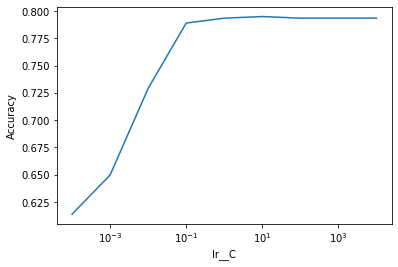

In [6]:
plot_gridsearchcv_results(search,'Accuracy',logvals=True)

**Using optimal logistic regression, sort features by coefficient**

In [7]:
from sklearn.model_selection import cross_validate

lrpipe = pipe.set_params(lr__C = 10^3).fit(X,y)
sortind=lrpipe['lr'].coef_.reshape(-1,1).argsort(axis=0)
for features, coefficients in zip(X.columns[sortind], lrpipe['lr'].coef_.reshape(-1,1)[sortind]):
    print(features,coefficients)
print('Accuracy score with simple imputer = ',np.mean(cross_validate(lrpipe, X, y, cv=5)['test_score']))

Age [[-2.93077519]]
SibSp [[-2.68145996]]
Pclass [[-1.61314326]]
CabinLetter_G [[-1.57900839]]
Embarked_S [[-0.50188095]]
Parch [[-0.35951437]]
Embarked_Q [[-0.19102045]]
Embarked_C [[-0.08787818]]
CabinLetter_D [[0.11224225]]
CabinLetter_C [[0.26955789]]
Fare [[0.48531003]]
CabinLetter_E [[0.74837014]]
CabinLetter_B [[0.84542655]]
CabinLetter_A [[1.2828671]]
CabinLetter_F [[1.84891132]]
CabinLetter_T [[2.15867151]]
Sex_female [[2.73478728]]
Accuracy score with simple imputer =  0.7949388396364044


**Perform analysis with iterative imputer**

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('lr',LogisticRegression(solver='liblinear',penalty='l2'))])

param_grid = {
    'lr__C': np.logspace(-4, 5, 10)
}
search = GridSearchCV(pipei, param_grid,cv=5)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.793):
{'lr__C': 1000.0}


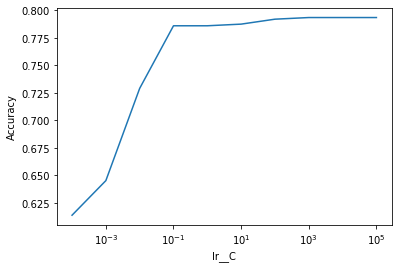

In [9]:
plot_gridsearchcv_results(search,'Accuracy',logvals=True)

**Look at feature significance and accuracy for iterative imputer results**

In [10]:
pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('lr',LogisticRegression(solver='liblinear',penalty='l1'))])
lrpipei = pipei.set_params(lr__C = 10^3).fit(X,y)
sortind=lrpipei['lr'].coef_.reshape(-1,1).argsort(axis=0)
for features, coefficients in zip(X.columns[sortind], lrpipei['lr'].coef_.reshape(-1,1)[sortind]):
    print(features,coefficients)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(lrpipei, X, y, cv=5)['test_score']))

Age [[-3.66259393]]
SibSp [[-3.57369959]]
Pclass [[-1.84162182]]
CabinLetter_G [[-1.77488085]]
Embarked_S [[-0.34400032]]
Parch [[-0.17662361]]
Embarked_Q [[0.]]
CabinLetter_D [[0.01027088]]
Embarked_C [[0.03266308]]
CabinLetter_C [[0.25553759]]
Fare [[0.32151955]]
CabinLetter_E [[0.66049121]]
CabinLetter_B [[0.81568857]]
CabinLetter_A [[1.26220338]]
CabinLetter_F [[2.37476827]]
Sex_female [[2.7328029]]
CabinLetter_T [[2.99627444]]
Accuracy score with iterative imputer =  0.7904387835259792


**Perform SVC analysis for comparison**

In [11]:
from sklearn.svm import SVC

pipe = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),('svc',SVC())])

param_grid = {
    'svc__C': np.logspace(-1, 2, 10),
    'svc__gamma' : np.logspace(-2,2,10) #These have both been narrowed down from broader+coarser searches
}
search = GridSearchCV(pipe, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)



Best parameter (CV score=0.805):
{'svc__C': 46.41588833612777, 'svc__gamma': 1.6681005372000592}


**Visualize how accuracy is affected by C and gamma when other parameter is set to maximum**

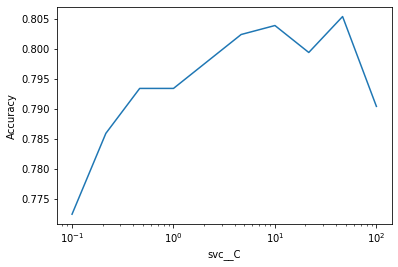

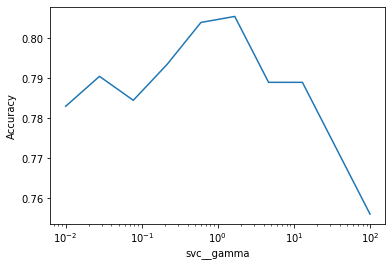

In [12]:
plot_gridsearchcv_results(search,'Accuracy',logvals=True)

In [13]:
svcpipe = pipe.set_params(svc__C = 1, svc__gamma = 1.668).fit(X,y)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(svcpipe, X, y, cv=5)['test_score']))

Accuracy score with iterative imputer =  0.7993940074065762


**Repeat for iterative imputer**

In [14]:
pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('svc',SVC())])

param_grid = {
    'svc__C': np.logspace(-1, 2, 10),
    'svc__gamma' : np.logspace(-2,2,10) #These have both been narrowed down from broader+coarser searches
}
search = GridSearchCV(pipei, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.808):
{'svc__C': 46.41588833612777, 'svc__gamma': 0.5994842503189409}


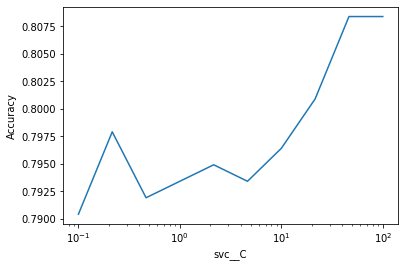

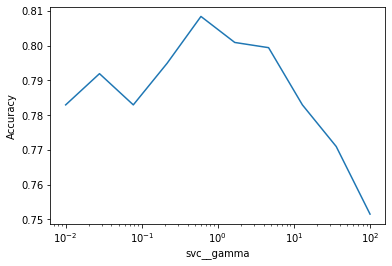

In [15]:
plot_gridsearchcv_results(search,'Accuracy',logvals=True)

In [16]:
pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('svc',SVC())])
svcpipe = pipei.set_params(svc__C = 1, svc__gamma = 1.668).fit(X,y)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(svcpipe, X, y, cv=5)['test_score']))

Accuracy score with iterative imputer =  0.7979014700931433


**Random forest classifier**

In [17]:
from sklearn.ensemble import RandomForestClassifier

piperfc = Pipeline(steps=[('imputer', SimpleImputer()), ('rfc',RandomForestClassifier(random_state=53))])

param_grid = {
    'rfc__max_depth': [2,3,4,5,6,7],
    'rfc__min_samples_leaf' : [1,2,3,4,5,6],
    'rfc__n_estimators' : [30,35,40,45]
}
search = GridSearchCV(piperfc, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.823):
{'rfc__max_depth': 6, 'rfc__min_samples_leaf': 3, 'rfc__n_estimators': 35}


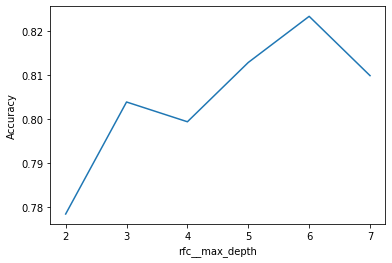

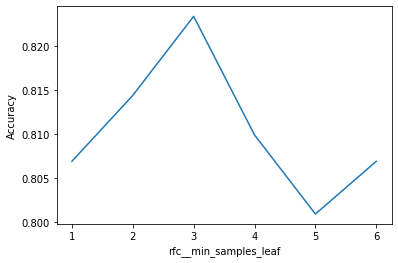

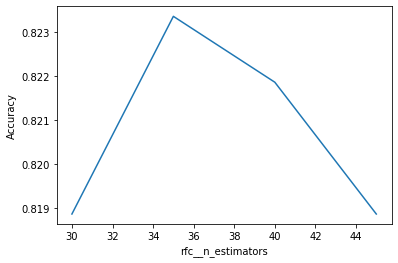

In [18]:
plot_gridsearchcv_results(search,'Accuracy')

In [19]:
rfcpipe = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(n_estimators=35,max_depth=6,min_samples_leaf=3,random_state=53))]).fit(X,y)
sortind=np.argsort(rfcpipe['rfc'].feature_importances_)
for features, coefficients in zip(X.columns[sortind], rfcpipe['rfc'].feature_importances_[sortind]):
    print(features,coefficients)
print('Accuracy score with simple imputer = ',np.mean(cross_validate(rfcpipe, X, y, cv=5)['test_score']))

CabinLetter_T 0.0
CabinLetter_G 0.0
CabinLetter_F 0.0013184595129704655
CabinLetter_E 0.0034700230600675994
CabinLetter_D 0.0044375696308834684
CabinLetter_A 0.0066612914976579155
CabinLetter_C 0.008080157767687215
Embarked_Q 0.01004120637334776
Embarked_S 0.014080457382698029
CabinLetter_B 0.014305598695964773
Embarked_C 0.018560289117559383
Parch 0.028459202559119438
SibSp 0.05192948316421288
Pclass 0.108326790189726
Age 0.1205088614488558
Fare 0.15774167321669655
Sex_female 0.4520789363825528
Accuracy score with simple imputer =  0.8038828414319379


**Repeat with iterative imputer**

In [ ]:
piperfci = Pipeline(steps=[('imputer', IterativeImputer()), ('rfc',RandomForestClassifier(random_state = 53))])

param_grid = {
    'rfc__max_depth': [5,6,7,8,9],
    'rfc__min_samples_leaf' : [2,3,4,5,6],
    'rfc__n_estimators' : [60,70,80,100,110,120,130]
}
search = GridSearchCV(piperfci, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
plot_gridsearchcv_results(search,'Accuracy')

In [ ]:
rfcpipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(n_estimators=120,max_depth=7,min_samples_leaf=2,random_state=53))]).fit(X,y)

sortind=np.argsort(rfcpipei['rfc'].feature_importances_)
for features, coefficients in zip(X.columns[sortind], rfcpipei['rfc'].feature_importances_[sortind]):
    print(features,coefficients)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(rfcpipei, X, y, cv=5)['test_score']))

**Now that the iterative imputer with random forest has been shown to give best results, train and apply it to the test set.**

In [ ]:
rfcpipe = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(n_estimators=120,max_depth=7,min_samples_leaf=2,random_state=53))]).fit(X,y)
y_test_predict = rfcpipe.predict(X_test)

print('Final accuracy score : ',accuracy_score(y_test,y_test_predict))